In [ ]:
import numpy as np
from collections import defaultdict

def draw_card():
    """Draw a card from the deck. Ace is 1, face cards are 10."""
    card = np.random.randint(1, 14)
    return min(card, 10)

def blackjack_step(state, action):
    """Take an action in blackjack: 'hit' or 'stick'."""
    player_sum, dealer_card, usable_ace = state
    
    if action == 'hit':
        card = draw_card()
        if card == 1:  # Ace
            if player_sum + 11 <= 21:
                player_sum += 11
                usable_ace = True
            else:
                player_sum += 1
        else:
            player_sum += card

        if player_sum > 21 and usable_ace:
            player_sum -= 10
            usable_ace = False
        
        if player_sum > 21:
            return (player_sum, dealer_card, usable_ace), -1, True  # Player busts
        else:
            return (player_sum, dealer_card, usable_ace), 0, False
    elif action == 'stick':
        dealer_sum = dealer_card
        while dealer_sum < 17:
            card = draw_card()
            dealer_sum += card if card != 1 else (11 if dealer_sum + 11 <= 21 else 1)
        
        if dealer_sum > 21 or player_sum > dealer_sum:
            return (player_sum, dealer_card, usable_ace), 1, True
        elif player_sum == dealer_sum:
            return (player_sum, dealer_card, usable_ace), 0, True
        else:
            return (player_sum, dealer_card, usable_ace), -1, True

def epsilon_greedy_policy(Q, state, epsilon):
    """Select an action using epsilon-greedy policy."""
    actions = ['hit', 'stick']
    if np.random.rand() < epsilon:
        return np.random.choice(actions)
    return max(actions, key=lambda a: Q[(state, a)])

def monte_carlo_control(episodes=500000, gamma=1.0, epsilon=0.1):
    """Monte Carlo Control with epsilon-greedy policy improvement."""
    Q = defaultdict(float)  # Action-value function
    returns_sum = defaultdict(float)
    returns_count = defaultdict(int)
    
    policy = defaultdict(lambda: 'hit')  # Initial policy
    
    for _ in range(episodes):
        # Generate an episode
        state = (np.random.randint(12, 22), draw_card(), bool(np.random.randint(2)))
        episode = []
        
        while True:
            action = epsilon_greedy_policy(Q, state, epsilon)
            next_state, reward, done = blackjack_step(state, action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        # Calculate returns and update Q-values
        G = 0
        visited = set()
        for state, action, reward in reversed(episode):
            G = gamma * G + reward
            if (state, action) not in visited:
                returns_sum[(state, action)] += G
                returns_count[(state, action)] += 1
                Q[(state, action)] = returns_sum[(state, action)] / returns_count[(state, action)]
                visited.add((state, action))
        
        # Update policy to be epsilon-greedy w.r.t Q
        for state, _, _ in episode:
            policy[state] = epsilon_greedy_policy(Q, state, epsilon)
    
    return Q, policy

# Run Monte Carlo Control
Q, policy = monte_carlo_control(episodes=100000, gamma=1.0, epsilon=0.4)

# Test the learned policy
state = (20, 10, False)  # Example state: Player sum 20, Dealer shows 10, No usable ace
print(f"Optimal action for state {state}: {policy[state]}")
print(f"Q-value for 'stick': {Q[(state, 'stick')]:.2f}")
print(f"Q-value for 'hit': {Q[(state, 'hit')]:.2f}")


Optimal action for state (20, 10, False): hit
Q-value for 'stick': 0.43
Q-value for 'hit': -0.92


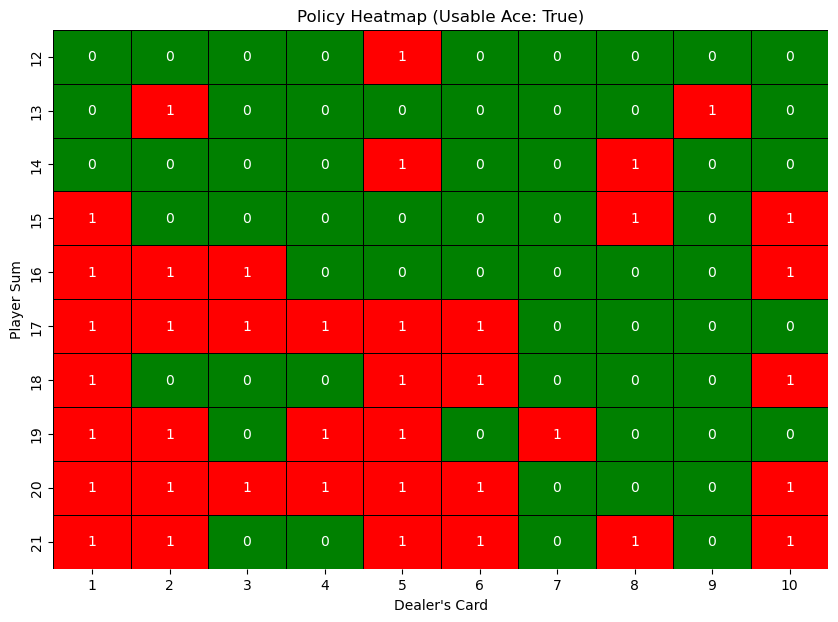

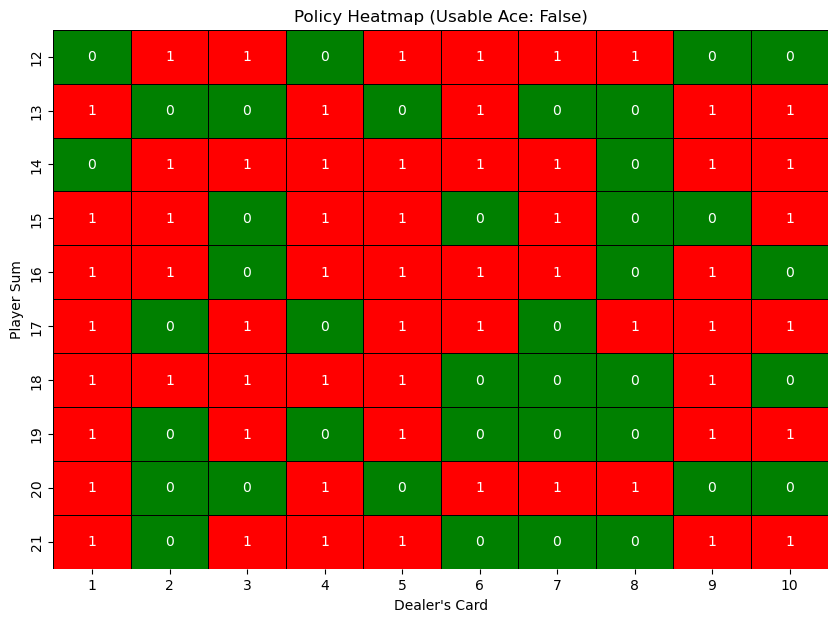

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_policy(policy, usable_ace=True):
    """Plot the policy as a heatmap with green for 'hit' and red for 'stick'."""
    player_sum_range = np.arange(12, 22)
    dealer_card_range = np.arange(1, 11)
    
    policy_grid = np.zeros((len(player_sum_range), len(dealer_card_range)))
    
    for i, player_sum in enumerate(player_sum_range):
        for j, dealer_card in enumerate(dealer_card_range):
            state = (player_sum, dealer_card, usable_ace)
            action = policy[state]
            policy_grid[i, j] = 1 if action == 'stick' else 0  # 1: stick, 0: hit

    plt.figure(figsize=(10, 7))
    cmap = sns.color_palette(["green", "red"])  # 绿色表示 hit，红色表示 stick
    sns.heatmap(policy_grid, annot=True, xticklabels=dealer_card_range,
                yticklabels=player_sum_range, cmap=cmap, cbar=False,
                linewidths=0.5, linecolor='black', fmt='.0f')
    plt.title(f"Policy Heatmap (Usable Ace: {usable_ace})")
    plt.xlabel("Dealer's Card")
    plt.ylabel("Player Sum")
    plt.show()

# Plot for usable ace
plot_policy(policy, usable_ace=True)

# Plot for no usable ace
plot_policy(policy, usable_ace=False)
